In [ ]:
TOT_TRANSACTIONS= 100;
NUM_USERS = 10;

In [ ]:
import json
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import time
from web3 import Web3


In [ ]:
# Connect to local Ethereum node
w3 = Web3(Web3.HTTPProvider('http://127.0.0.1:8545'))
w3.eth.default_account = w3.eth.accounts[0]

# Load contract address and ABI
with open('contract_address.txt', 'r') as file:
    contract_address = file.read()

with open('contract_abi.json', 'r') as file:
    abi = json.load(file)

# Create contract instance
contract = w3.eth.contract(address=contract_address, abi=abi)

# Start overall timer
overall_start = time.time()

In [ ]:


# Step 1: Generate a Connected Network
network_start = time.time()
num_users = NUM_USERS
G = nx.connected_watts_strogatz_graph(n=num_users, k=4, p=0.5, tries=100)
if not nx.is_connected(G):
    print("Generated graph is not connected.")
    G = nx.connected_watts_strogatz_graph(n=num_users, k=4, p=0.5, tries=100)
network_end = time.time()
print(f"Network generation time: {network_end - network_start:.2f} seconds")

In [ ]:
# Step 2: Register Users
registration_start = time.time()
for node in G.nodes():
    tx = contract.functions.registerUser(node, f"User{node}").transact()
    w3.eth.wait_for_transaction_receipt(tx)
registration_end = time.time()
print(f"User registration time: {registration_end - registration_start:.2f} seconds")

In [ ]:
# Step 3: Create Joint Accounts
account_start = time.time()
edge_list = list(G.edges())
balances = np.random.exponential(scale=10, size=len(edge_list))
print("Creating joint accounts...")
for i, (u1, u2) in enumerate(edge_list):
    initial_contribution = max(int(balances[i] / 2), 1)  # Ensure at least 1
    tx = contract.functions.createAcc(u1, u2, initial_contribution).transact()
    w3.eth.wait_for_transaction_receipt(tx)
print("All joint accounts created.")
account_end = time.time()
print(f"Account creation time: {account_end - account_start:.2f} seconds")

Network generation time: 0.00 seconds
User registration time: 6.45 seconds
Creating joint accounts...
All joint accounts created.
Account creation time: 19.23 seconds
Simulating transactions...
Transaction from User3 to User0 failed: The response was in an unexpected format and unable to be parsed. Response cannot include both "error" and "result". The raw response is: {'id': 298, 'jsonrpc': '2.0', 'result': '0xb357f9adeb92aa8addb9990145d0e4f288e06ed2d33cdfce9030c328e84923e3', 'error': {'message': 'VM Exception while processing transaction: revert Insufficient balance in account', 'code': -32000, 'data': {'0xb357f9adeb92aa8addb9990145d0e4f288e06ed2d33cdfce9030c328e84923e3': {'error': 'revert', 'program_counter': 2638, 'return': '0x08c379a00000000000000000000000000000000000000000000000000000000000000020000000000000000000000000000000000000000000000000000000000000001f496e73756666696369656e742062616c616e636520696e206163636f756e7400', 'reason': 'Insufficient balance in account'}, 'stack': '

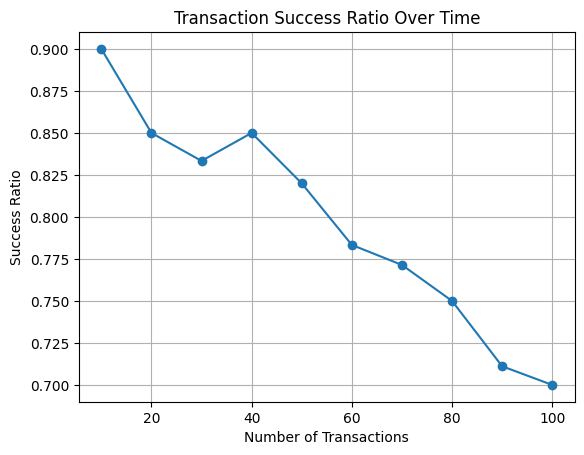

Plot generation time: 0.34 seconds
Total simulation time: 64.31 seconds


In [ ]:
# Step 4: Simulate Transactions
transaction_start = time.time()
success_count = 0
total_transactions = 0
success_ratios = []

print("Simulating transactions...")
for i in range(TOT_TRANSACTIONS):
    sender = random.choice(list(G.nodes()))
    receiver = random.choice(list(G.nodes()))
    while receiver == sender:
        receiver = random.choice(list(G.nodes()))

    amount = 1  # Unit amount

    # Perform pathfinding off-chain
    try:
        path = nx.shortest_path(G, source=sender, target=receiver)
    except nx.NetworkXNoPath:
        path = []

    if path:
        # Send transaction
        try:
            tx = contract.functions.sendAmount(sender, receiver, amount, path).transact({'gas': 3000000})
            w3.eth.wait_for_transaction_receipt(tx)
            success_count += 1
        except Exception as e:
            print(f"Transaction from User{sender} to User{receiver} failed: {e}")
    else:
        print(f"No path found between User{sender} and User{receiver}")
    total_transactions += 1

    if (i + 1) % 10 == 0:
        success_ratio = success_count / total_transactions
        success_ratios.append(success_ratio)
        print(f"After {total_transactions} transactions, success ratio: {success_ratio:.2f}")

transaction_end = time.time()
print(f"Transaction simulation time: {transaction_end - transaction_start:.2f} seconds")

